Found 9867 images belonging to 4 classes.
Found 2465 images belonging to 4 classes.
Found 3076 images belonging to 4 classes.
Epoch 1/20
309/309 [==============================] - 1173s 4s/step - loss: 1.8117 - accuracy: 0.6837 - val_loss: 1.3392 - val_accuracy: 0.8625
Epoch 2/20
309/309 [==============================] - 1146s 4s/step - loss: 1.3079 - accuracy: 0.8541 - val_loss: 1.1377 - val_accuracy: 0.9120
Epoch 3/20
309/309 [==============================] - 1143s 4s/step - loss: 1.1286 - accuracy: 0.8999 - val_loss: 1.0282 - val_accuracy: 0.9254
Epoch 4/20
309/309 [==============================] - 1145s 4s/step - loss: 1.0285 - accuracy: 0.9188 - val_loss: 0.9454 - val_accuracy: 0.9428
Epoch 5/20
309/309 [==============================] - 1130s 4s/step - loss: 0.9483 - accuracy: 0.9309 - val_loss: 0.8939 - val_accuracy: 0.9420
Epoch 6/20
309/309 [==============================] - 1142s 4s/step - loss: 0.8840 - accuracy: 0.9401 - val_loss: 0.8416 - val_accuracy: 0.9428
Epoch 7/20

C:\Users\nksdk\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


97/97 [==============================] - 142s 1s/step
Confusion Matrix:
[[380   2  26   0]
 [  0 952   0   0]
 [ 37   0 751   0]
 [  1   0   0 927]]


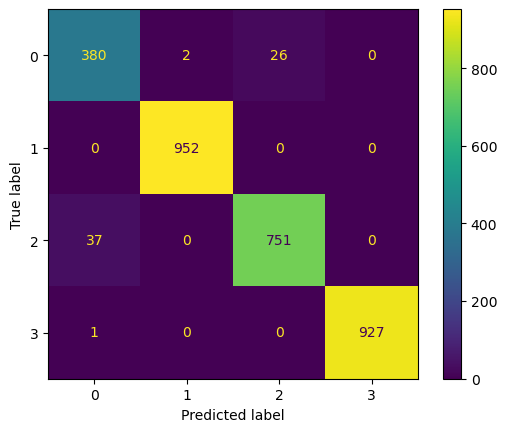

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       408
           1       1.00      1.00      1.00       952
           2       0.97      0.95      0.96       788
           3       1.00      1.00      1.00       928

    accuracy                           0.98      3076
   macro avg       0.97      0.97      0.97      3076
weighted avg       0.98      0.98      0.98      3076



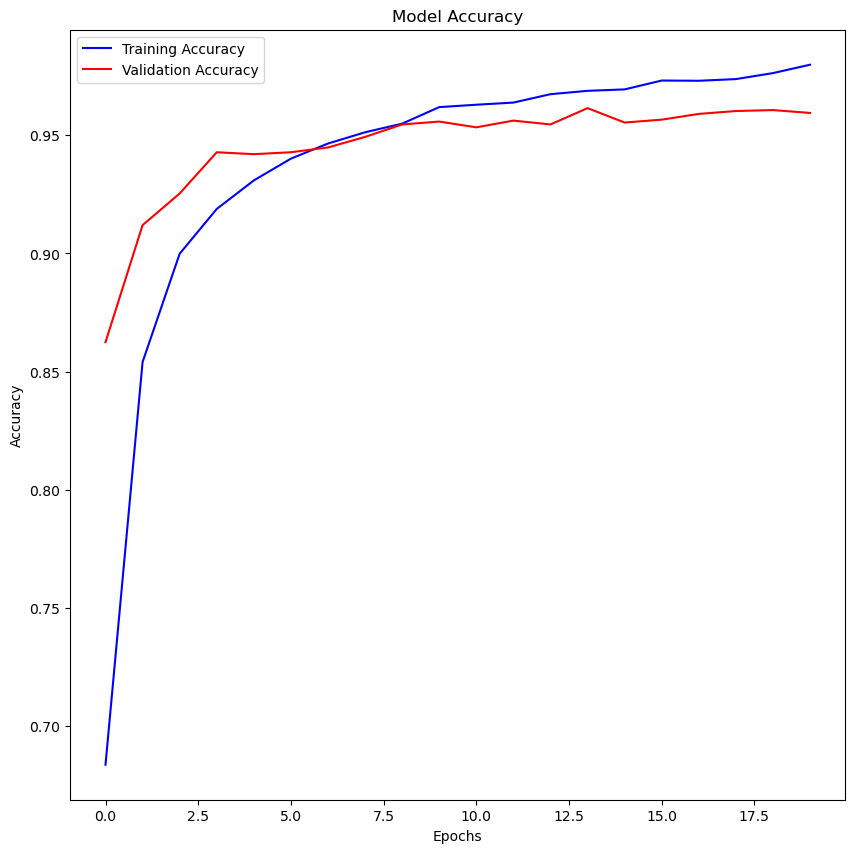

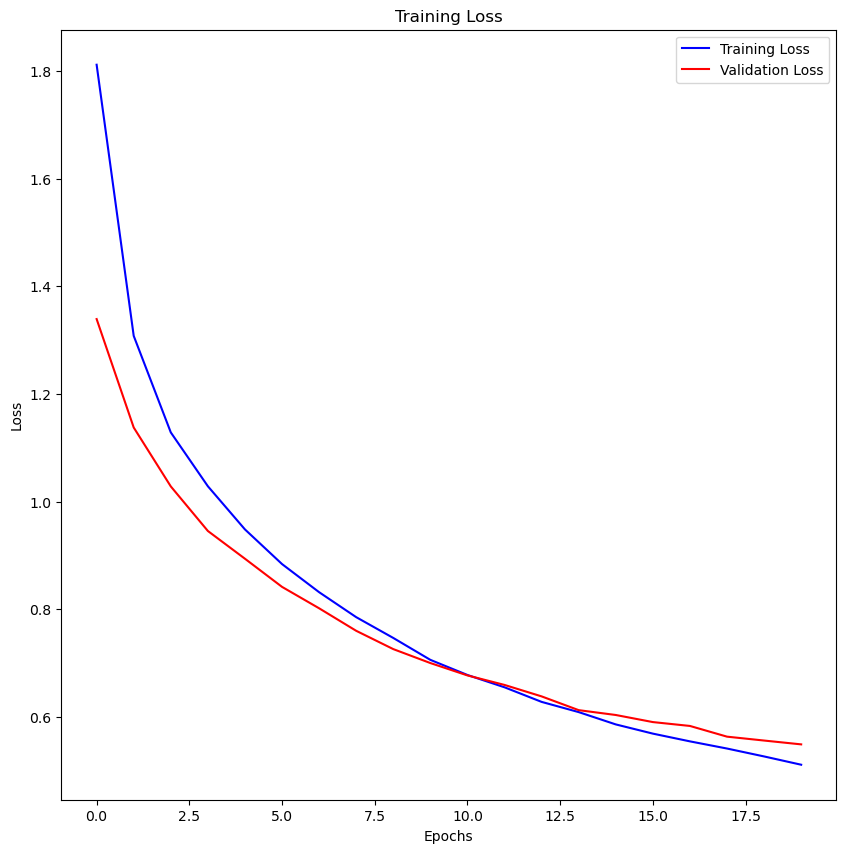

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 1. Data Preparation
# Define file paths
train_file_path = 'Train'
test_file_path = 'Test'

# Define parameters
input_size = (244, 244)
image_color = 'rgb'
batch_size = 32
valid_split = 0.2  # Define the validation split

# Create ImageDataGenerator for training and testing
train_gen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,      
    shear_range=0.2,        
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=valid_split,  # Use validation split
    fill_mode='nearest'
)

test_gen = ImageDataGenerator(rescale=1/255.0)

# Load training data with validation split
train_data = train_gen.flow_from_directory(
    directory=train_file_path,
    target_size=input_size,
    color_mode=image_color,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    subset='training'  # Training subset
)

valid_data = train_gen.flow_from_directory(
    directory=train_file_path,
    target_size=input_size,
    color_mode=image_color,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    subset='validation'  # Validation subset
)

# Load testing data (note: shuffle set to False for evaluation consistency)
test_data = test_gen.flow_from_directory(
    directory=test_file_path,
    target_size=input_size,
    color_mode=image_color,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

# 2. Model Building & Fine-Tuning
# Define input shape and number of classes
input_shape = (244, 244, 3)
num_classes = 4

# Create the base pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Unfreeze only the last 50 layers for fine-tuning; freeze the rest
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Build new top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)  # L2 regularization
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(num_classes, activation='softmax')(x)

# Combine the base model and new layers into a final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# 3. Model Training
# Define EarlyStopping callback to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with the EarlyStopping callback
history = model.fit(train_data, 
                    epochs=20, 
                    validation_data=valid_data, 
                    callbacks=[early_stop])

# Save the fine-tuned model
model.save("densenet.h5")

# 4. Model Evaluation
# Reload the saved model 
model = keras.models.load_model("densenet.h5")

# Predict on test data
predictions_prob = model.predict(test_data)
predictions_class = np.argmax(predictions_prob, axis=1)

# Compute and display confusion matrix
cm = confusion_matrix(test_data.classes, predictions_class)
print("Confusion Matrix:")
print(cm)
ConfusionMatrixDisplay(cm).plot()
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(test_data.classes, predictions_class))

# 5. Plotting Training History
# Plot model accuracy
plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot model loss
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'], color='red', label='Validation Loss')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
